In [1]:
import astropy.io.fits as pf
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import requests
from astropy.io import fits
from astropy.utils.data import download_file

import sys
import os
import cv2
#sys.path.append(os.path.join('C:/', 'Users', 'ASUS', 'Documents', 'GitHub', 'satmetrics'))
#sys.path.append(os.path.join('C:/', 'Users', 'ASUS', 'Documents', 'GitHub', 'reca-streaks'))

sys.path.append('../../../satmetrics')
sys.path.append('../../../reca-streaks')

import line_detection_updated as ld
from photutils.background import Background2D

import image_rotation as ir
import streak_photometry

In [3]:
import pixelplot

In [4]:
def plot_decam_image(image, expnum=None, detector=None):
    """
    Displays a DECam image using matplotlib, with some basic contrast scaling 
    and optional labels for exposure number and detector.
    """
    # Compute contrast limits using percentiles
    vmin = np.percentile(image, 5)
    vmax = np.percentile(image, 95)

    # Transpose for better visual orientation
    img = np.flip(image.T)

    # Plot
    plt.figure(figsize=(10, 10))
    plt.imshow(img, cmap='gray', origin='lower', vmin=vmin, vmax=vmax)
    
    title = "DECam Image"
    if expnum is not None and detector is not None:
        title += f" — expnum {expnum}, detector {detector}"
    elif expnum is not None:
        title += f" — expnum {expnum}"
    elif detector is not None:
        title += f" — detector {detector}"
    
    plt.title(title, fontsize=14)
    plt.xlabel("Pixels")
    plt.ylabel("Pixels")
    plt.grid(False)
    plt.tight_layout()
    plt.show()

In [5]:

#def detect_lines_hough(image, threshold=0.075, **kwargs):
def detect_lines_hough(image, threshold=0.075, flux_prop_thresholds=[0.1,0.2,0.3,1], 
                       blur_kernel_sizes=[3,5,9,11], brightness_cuts=(2,2), thresholding_cut=0.5 ,**kwargs):

    """
    Applies Hough Transform line detection on a DECam image using the custom satmetrics module.

    Parameters:
        image (ndarray): 2D image array.
        **kwargs: Optional keyword arguments to pass into the LineDetection object (e.g. thresholds).
    """
    lineDetector = ld.LineDetection(image)
    lineDetector.threshold = threshold
    lineDetector.flux_prop_thresholds = flux_prop_thresholds
    lineDetector.blur_kernel_sizes = blur_kernel_sizes
    lineDetector.brightness_cuts = brightness_cuts
    lineDetector.thresholding_cut = thresholding_cut
    # Detector instance
   # lineDetector = ld.LineDetection(image)
    #lineDetector.threshold = 0.012 it could break the threshold
    for key, value in kwargs.items():
        setattr(lineDetector, key, value)

    # Hough transform
    detections = lineDetector.hough_transformation()
    return detections


In [6]:
def rotate_streak_horizontal(image, lines):
    """
    Rotates the image so that the main detected streak (line) is horizontal.
    
    """
    if lines is None or len(lines) == 0:
        raise ValueError("No lines detected to use for rotation.")
    
    line = lines[0]
    coords = [[line[0], line[1]], [line[2], line[3]]]
    angle = ir.determine_rotation_angle(coords)
    rotated_image = ir.rotate_image(image, angle, coords)
    
    return rotated_image, coords, angle


In [7]:
#file_name = "../../../D00958013_N28.fits.fz"
file_name = "../../../subset.c4d_220915_081902_ooi_i_v1.fits.fz"
hdulist = pf.open(file_name)

In [8]:
hdulist.info()

Filename: ../../../subset.c4d_220915_081902_ooi_i_v1.fits.fz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     208   ()      
  1  S26           1 CompImageHDU    154   (2046, 4094)   float32   


In [9]:
with pf.open(file_name) as hdul:
    hdu_names = [hdu.name for hdu in hdul]

print(hdu_names)

['PRIMARY', 'S26']


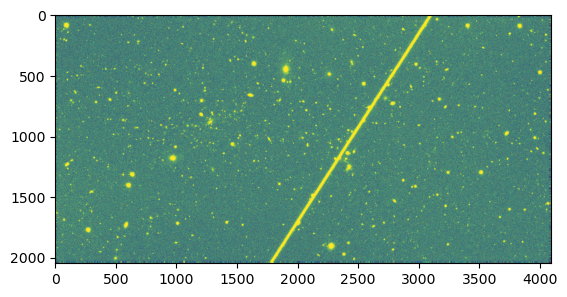

In [10]:

image_data = hdulist[1].data
plt.imshow(image_data.T, vmin = np.percentile(image_data,5),
          vmax = np.percentile(image_data, 95))

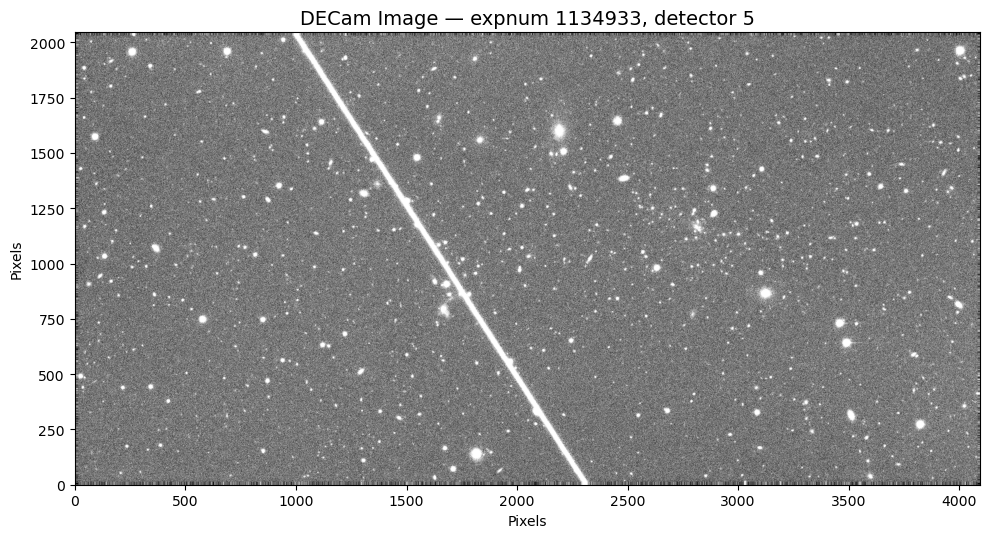

In [11]:
expnum = 1134933  
detector = 5     

if image_data is not None:
    plot_decam_image(image_data, expnum=expnum, detector=detector)

In [12]:
detected_lines = detect_lines_hough(image_data)

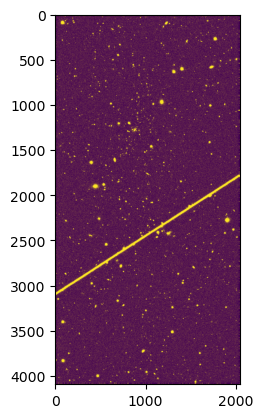

In [13]:
plt.imshow(detected_lines['Thresholded Image'])

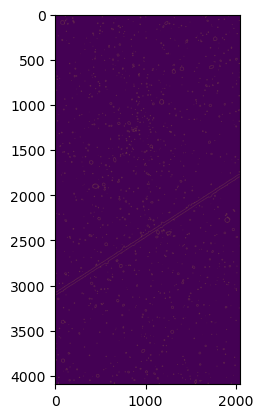

In [14]:
plt.imshow(detected_lines['Edges'])

In [15]:
clustered_lines = ld.cluster(detected_lines["Cartesian Coordinates"], detected_lines["Lines"])

In [16]:
clustered_lines

array([[2.61500000e+03, 9.94837674e-01, 0.00000000e+00],
       [2.58900000e+03, 9.94837674e-01, 0.00000000e+00]])

In [17]:
rotated_images, best_fit_params = ir.complete_rotate_image(
                                                clustered_lines=clustered_lines,
                                                angles=detected_lines["Angles"],
                                                image=image_data,
                                                cart_coord=detected_lines['Cartesian Coordinates'])

In [18]:
print(rotated_images)

[array([[1222.21070266, 1206.39605618, 1236.91362381, ..., 1217.36029315,
        1227.2150116 , 1214.21100616],
       [1237.2790339 , 1220.7660017 , 1248.33182919, ..., 1223.65829849,
        1232.08620942, 1218.81389499],
       [1222.81180894, 1214.65749741, 1222.36994171, ..., 1226.23801589,
        1243.27620029, 1229.61952877],
       ...,
       [1228.32498074, 1212.01935577, 1220.21172333, ..., 1248.46909571,
        1224.99182844, 1212.97625959],
       [1230.00720739, 1230.88062096, 1210.73395348, ..., 1224.75546443,
        1226.81957436, 1209.0976181 ],
       [1225.24703026, 1227.54830194, 1216.58328533, ..., 1206.43986511,
        1228.70238972, 1211.02517581]], shape=(100, 2046))]


Regime: source-dominated
Flux (e⁻): 111023375.78
Noise background variance: 2925988181.73 e⁻²
Flux error: 15666.71 ADU
SNR: 2014.6

=== Aperture Photometry Result ===
Streak center (y0): 51.82 px
Width: σ = 3.38 px, FWHM ≈ 7.95 px
Streak flux: 31562329.97 ADU ± 15666.71
Surface brightness: 27953.08 ± 13.88 counts/arcsec² [source-dominated]
SNR: 2014.61
(Using zeropoint 30.05)
Surface brightness: 18.935 ± 0.001 mag/arcsec²


/opt/lsst/software/stack/conda/envs/lsst-scipipe-10.1.0/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:868: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


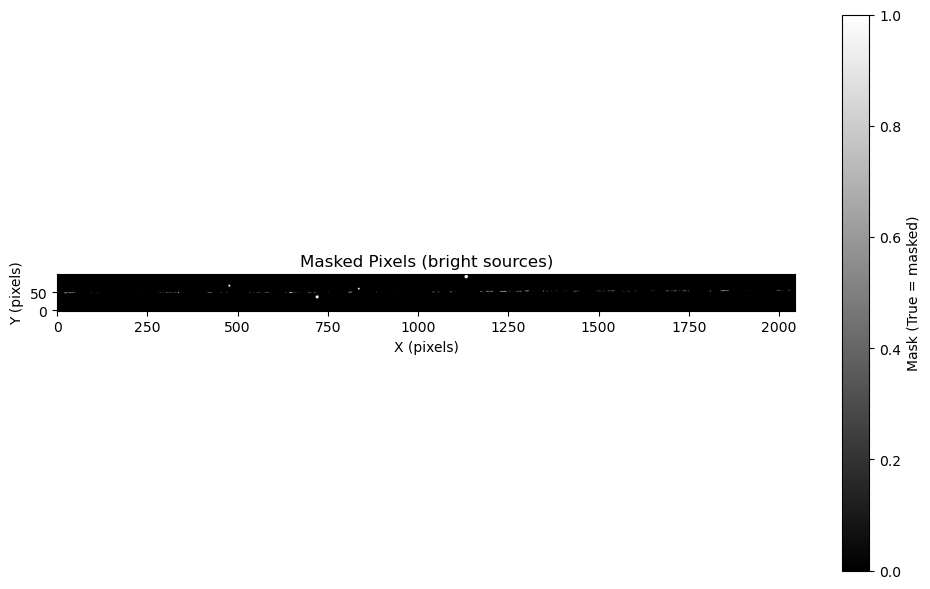

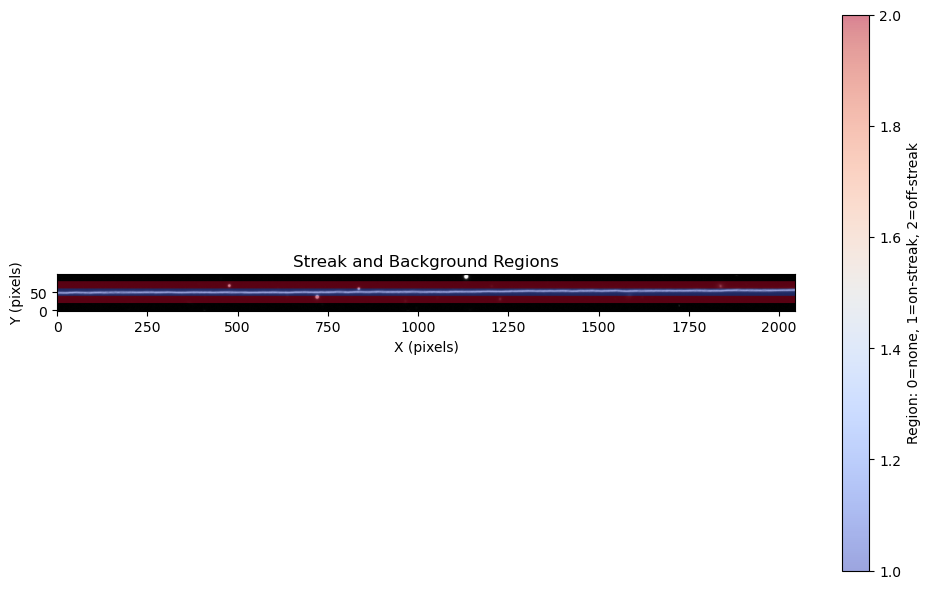

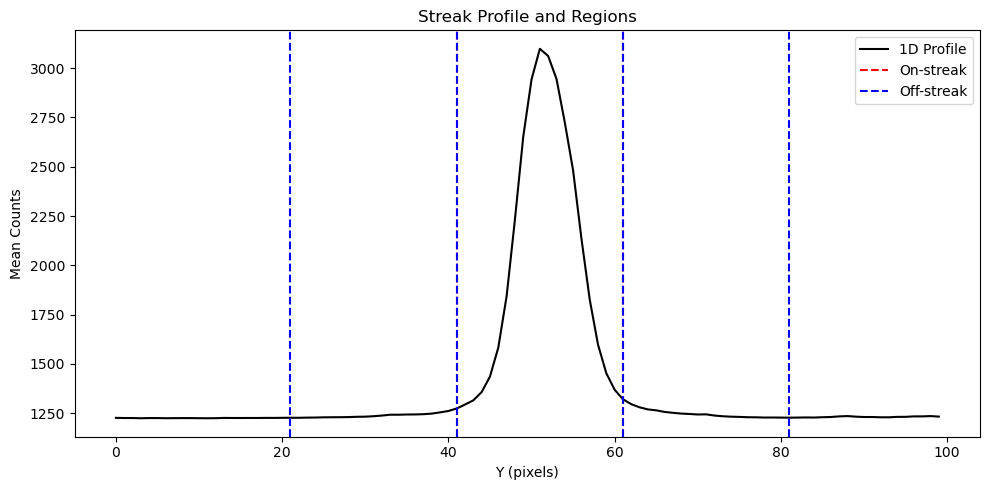

(np.float64(27953.081142892304), np.float64(13.875175313526547))

In [19]:
streak_photometry.streak_photometry(rotated_images[0], hdu_list = hdulist)

Average amp gain (e/ADU) 3.517591251445055
Average read noise (e) 6.31216
zero point [mag]:  30.051
Hola
length  2068.3525857633604
width 6.942457133001167
Npix 14359

=== Trail Fit Results (θ free) ===
Background: 1243.23 counts/pixel
Total flux (phi): 31552633.07 ± 0.01 ADU
Trail length (L): 2054.47 px
PSF sigma: 2.31 px → FWHM = 5.45 px --> 1.44 arcsec 
Trail angle θ: -0.20 deg
Center: x0 = 1020.63, y0 = 51.88
Surface brightness: 40618.31 ± 0.00 counts/arcsec²
S/N (section 3): 4509.6
Chi²: 1427095.14
Reduced Chi²: 102.0082

Surface brightness (mag/arcsec²): 18.53 ± 0.0002
Signal-to-noise ratio (SNR): 4509.6


{'SB_counts': np.float64(40618.313806826736),
 'SB_counts_err': np.float64(1.6821295839963086e-05),
 'SB_mag': np.float64(18.529195273696224),
 'SB_mag_err': np.float64(0.000240754654705281),
 'Zeropoint': 30.051,
 'Background': np.float64(1243.234961635309),
 'Flux_total': np.float64(31552633.07459847),
 'Flux_err': np.float64(0.013066917991766082),
 'Trail_Length_px': np.float64(2054.467671497358),
 'PSF_Sigma_px': np.float64(2.3141523776670554),
 'PSF_FWHM_arcsec': np.float64(1.4354849189335184),
 'Trail_angle_deg': np.float64(-0.1950160608826839),
 'Center_x0': np.float64(1020.6257130494291),
 'Center_y0': np.float64(51.878405856986674),
 'SNR': np.float64(4509.570132004535),
 'Chi2': np.float64(1427095.139049694),
 'Chi2_red': np.float64(102.00823009647561)}

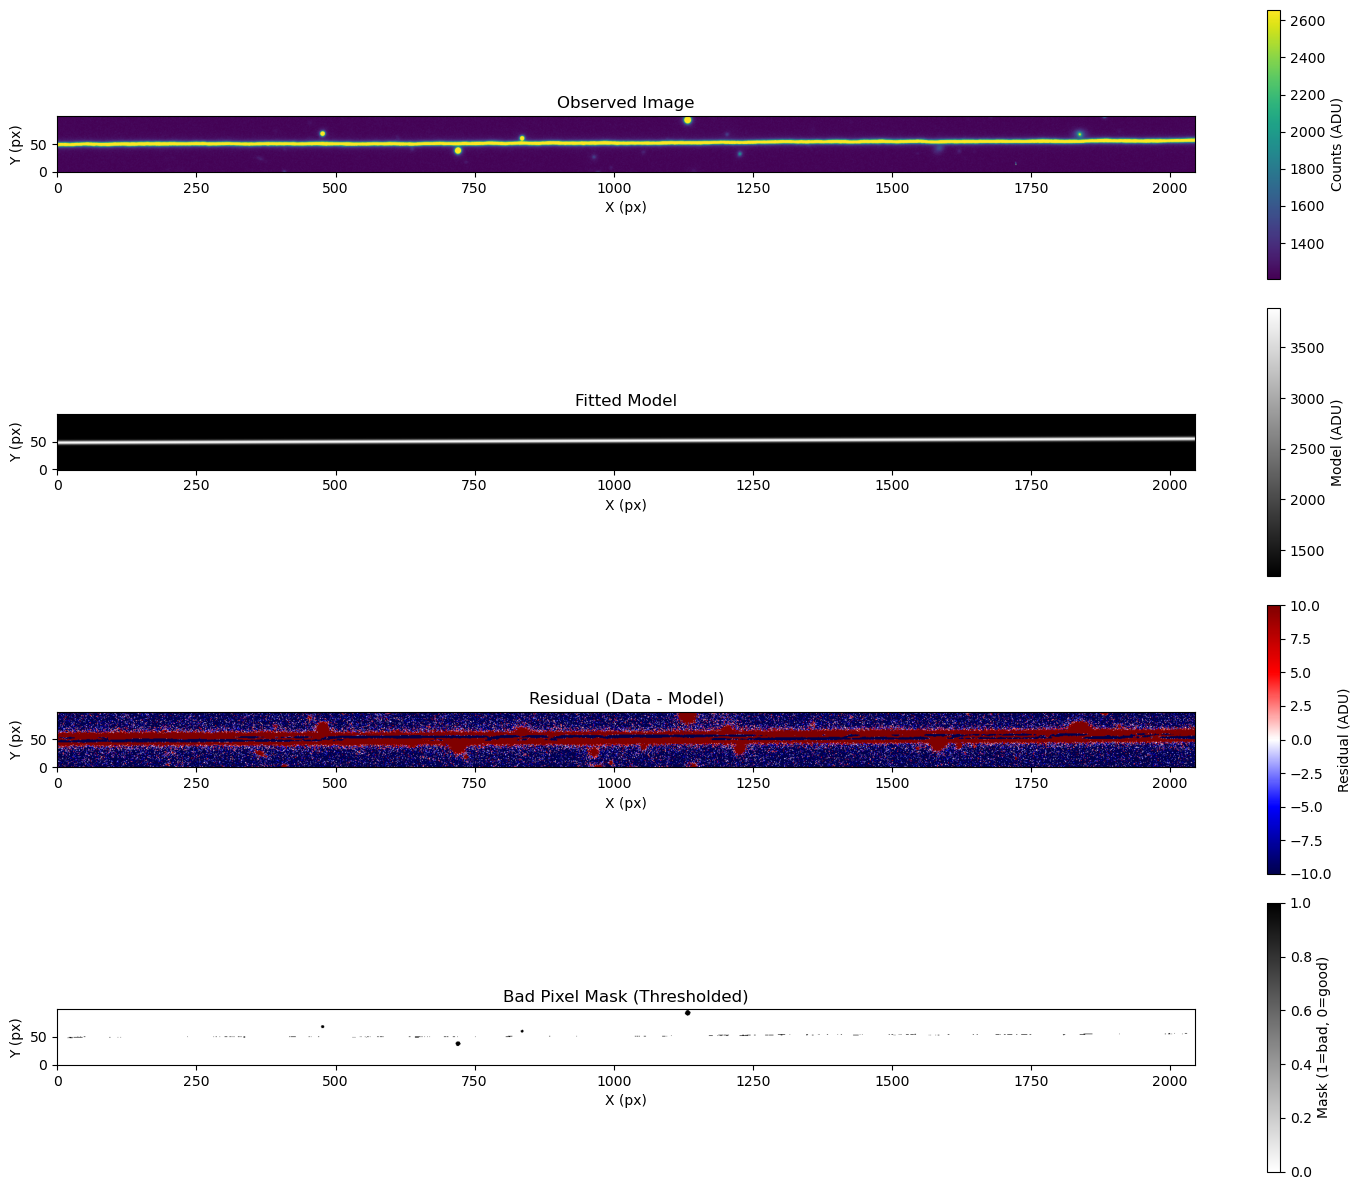

In [20]:
streak_photometry.streak_photometry_psf_fitting(rotated_images[0], hdu_list = hdulist)

In [21]:
# Simulation 

In [22]:
sim_file_name = "../../../simulated_psf_convolved_trail.fits"

In [23]:
hdulist_sim = pf.open(sim_file_name)

In [24]:
hdulist_sim.info()

Filename: ../../../simulated_psf_convolved_trail.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 ImageHDU        11   (2048, 100)   float32   


In [25]:
data_sim = hdulist_sim[1].data

Photometric zeropoint not available in image header, reporting instrumental flux only.
Regime: source-dominated
Flux (e⁻): 9824238.55
Noise background variance: 23052697.50 e⁻²
Flux error: 1451.61 ADU
SNR: 1713.4

=== Aperture Photometry Result ===
Streak center (y0): 49.50 px
Width: σ = 1.51 px, FWHM ≈ 3.55 px
Streak flux: 2487149.00 ADU ± 1451.61
Surface brightness: 4935.05 ± 2.88 counts/arcsec² [source-dominated]
SNR: 1713.38


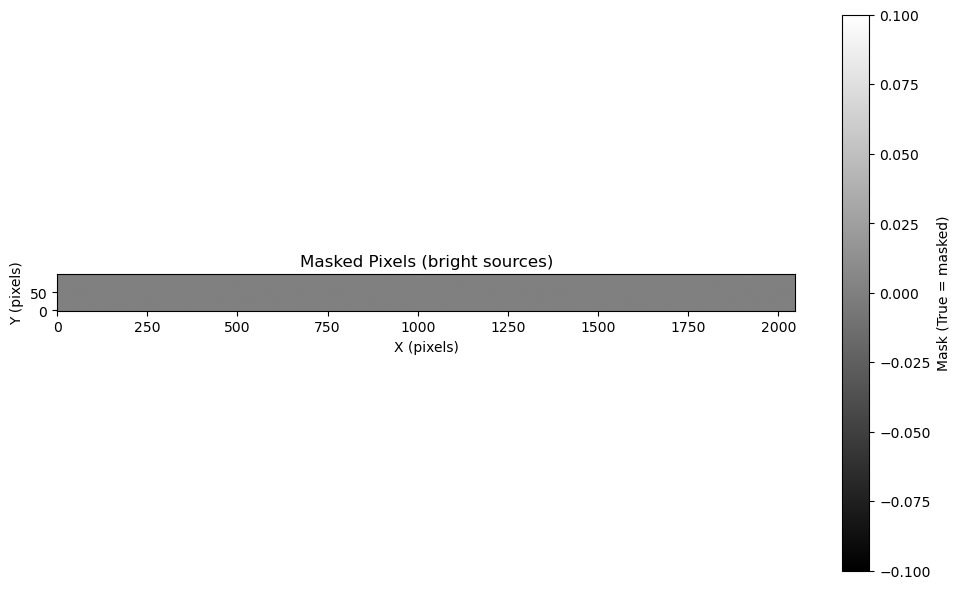

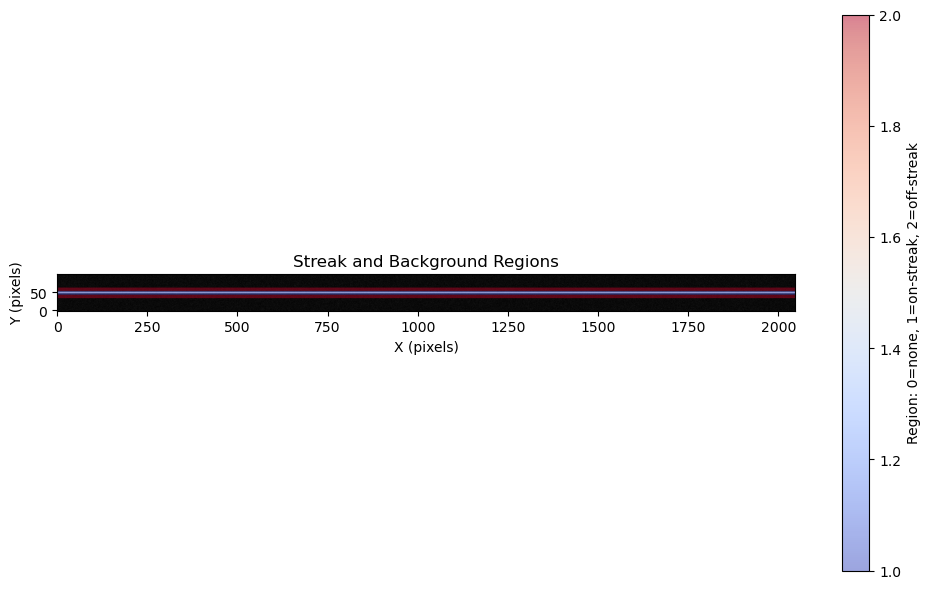

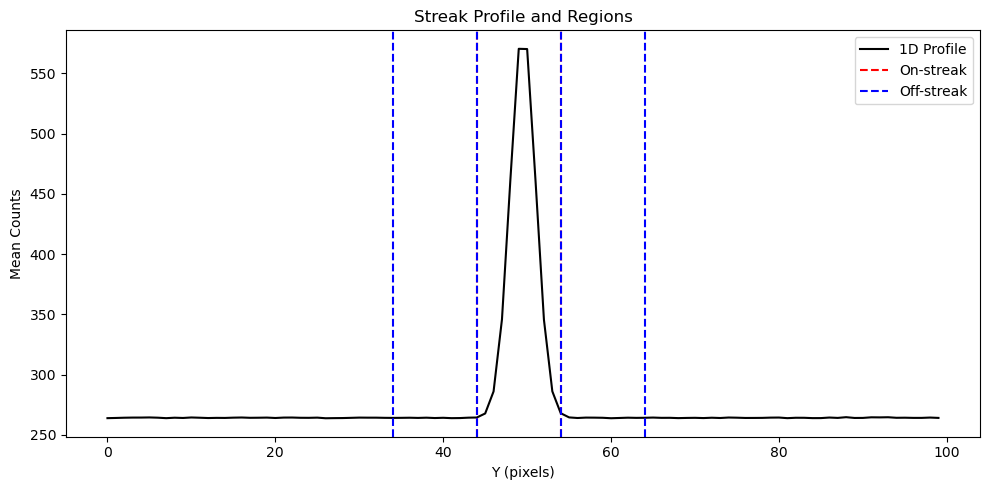

(np.float64(4935.053604137435), np.float64(2.880306094722628))

In [26]:
streak_photometry.streak_photometry(data_sim,
                                    hdu_list = hdulist_sim,
                                    sigma_mask=10)

Photometric zeropoint not available in image header, reporting instrumental flux only.
Average amp gain (e/ADU) 3.95
Average read noise (e) 6.0
No MAGZERO keyword in header
Hola
length  2057.028431764649
width 4.518342187859351
Npix 9294

=== Trail Fit Results (θ free) ===
Background: 264.22 counts/pixel
Total flux (phi): 2500499.01 ± 9613.44 ADU
Trail length (L): 2047.99 px
PSF sigma: 1.51 px → FWHM = 3.55 px --> 0.93 arcsec 
Trail angle θ: -0.00 deg
Center: x0 = 1023.45, y0 = 49.50
Surface brightness: 4961.56 ± 19.08 counts/arcsec²
S/N (section 3): 1157.7
Chi²: 8167.70
Reduced Chi²: 0.9980
Image with no zero point, can't convert to magnitude


{'SB_counts': np.float64(4961.559100871729),
 'SB_counts_err': np.float64(19.07526244346659),
 'SB_mag': 'No zeropoint',
 'SB_mag_err': '—',
 'Zeropoint': 'No zeropoint',
 'Background': np.float64(264.21801575108583),
 'Flux_total': np.float64(2500499.0130971535),
 'Flux_err': np.float64(9613.44487584096),
 'Trail_Length_px': np.float64(2047.9917473889304),
 'PSF_Sigma_px': np.float64(1.5061140626197835),
 'PSF_FWHM_arcsec': np.float64(0.9342530958414902),
 'Trail_angle_deg': np.float64(-0.00011960607125582499),
 'Center_x0': np.float64(1023.4524302117402),
 'Center_y0': np.float64(49.49763688695164),
 'SNR': np.float64(1157.7162263382963),
 'Chi2': np.float64(8167.700837367471),
 'Chi2_red': np.float64(0.9980084112130341)}

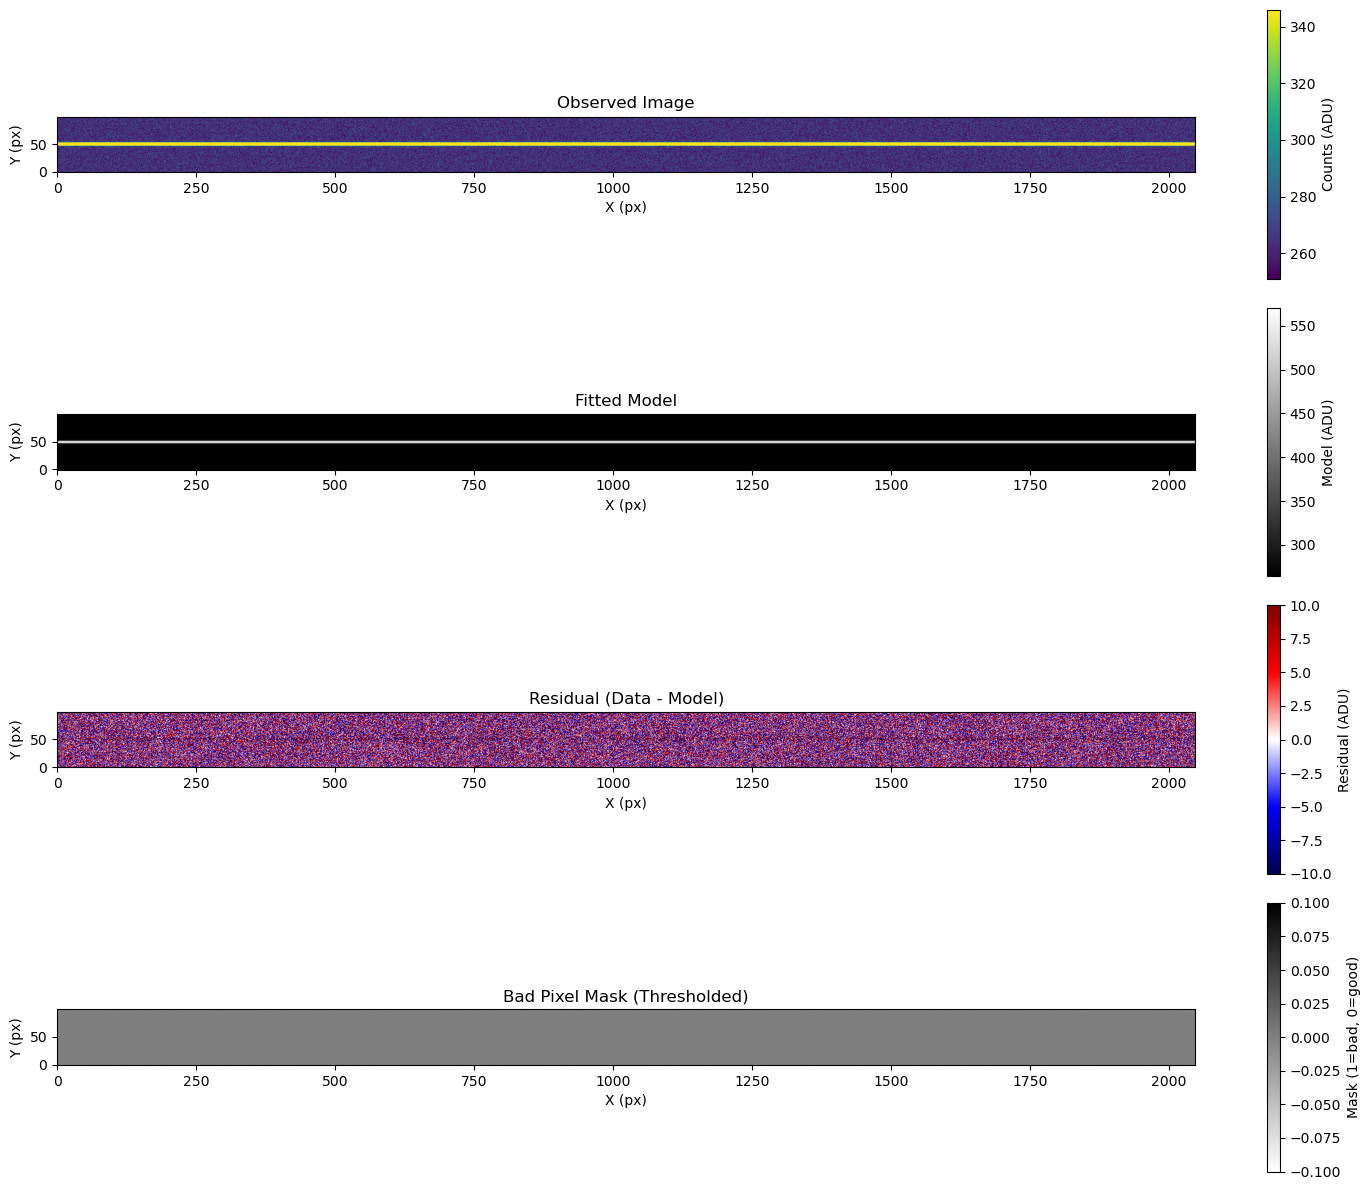

In [27]:
streak_photometry.streak_photometry_psf_fitting(data_sim,
                                    hdu_list = hdulist_sim,
                                    sigma_mask=10)

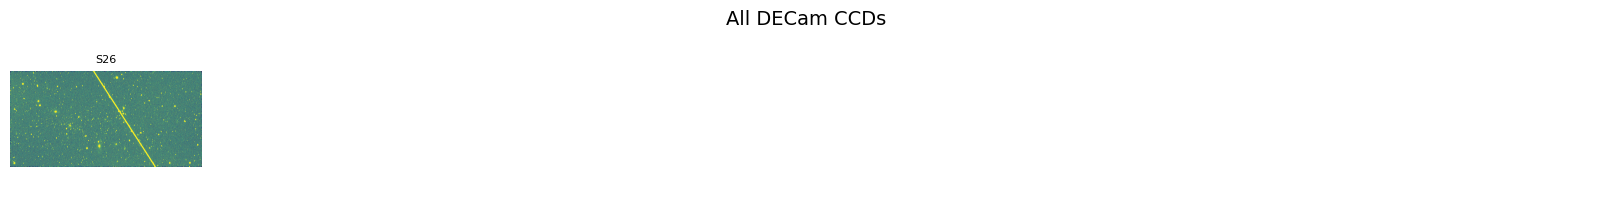

In [28]:
# Get all HDU names with image data (skip PRIMARY)
hdu_names = [hdu.name for hdu in hdulist if hdu.data is not None and hdu.name != 'PRIMARY']
n_images = len(hdu_names)

# Set grid size (e.g., 8x8 for 62 CCDs)
ncols = 8
nrows = int(np.ceil(n_images / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(16, 2*nrows), constrained_layout=True)

for i, hdu_name in enumerate(hdu_names):
    row, col = divmod(i, ncols)
    ax = axes[row, col] if nrows > 1 else axes[col]
    
    try:
        data = hdulist[hdu_name].data
        vmin = np.percentile(data, 5)
        vmax = np.percentile(data, 95)
        ax.imshow(data.T, origin='lower'
                  , vmin=vmin, vmax=vmax)
        ax.set_title(hdu_name, fontsize=8)
    except Exception as e:
        ax.set_title(f"{hdu_name} (error)")
        print(f"Skipping {hdu_name} due to error: {e}")
    
    ax.axis('off')

# Hide unused axes
for j in range(i+1, nrows*ncols):
    row, col = divmod(j, ncols)
    ax = axes[row, col] if nrows > 1 else axes[col]
    ax.axis('off')

plt.suptitle("All DECam CCDs", fontsize=14)
plt.show()
hdulist.close()
